# Modified 3D PMRNN

## Module Imports

In [1]:
# import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import os
import cv2
import import_ipynb
import Utils
# from skimage import util


In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.5.0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras import layers,losses,Sequential,metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.image import ssim

In [5]:
from CBAM import ConvolutionBlockAttentionModule

In [6]:
from tensorflow.keras import backend as K

In [7]:
import tensorflow._api.v2.compat.v1 as tf1

## Model Config

In [8]:
CONFIGURATION = {
    "BATCH_SIZE": 10,
    "LEARNING_RATE": 1e-3,
    "OPTIMIZER":Adam,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 5,
    "INPUT_SHAPE":(256,256,1),
    "LATENT_SPACE_DIM" : 64,
    "REDUCED_DIMENSION" : 256,
}

## reading data

In [9]:
image_data = Utils.read_data("Berea_2d25um_binary.raw")
image_data.shape

(1000, 1000, 1000)

## Voxel extraction 

In [10]:
voxels = Utils.extract_subvolumes(image_data)
voxels.shape

(64, 250, 256, 256, 1)

In [11]:
del image_data

## Loss Functions

In [12]:
def calculate_kl_loss(model):
    def _calculate_kl_loss(*args):
        kld = tf.keras.losses.KLDivergence()
        kl_loss = kld(model.inferenceDistribution,model.learnedDistribution)
        return kl_loss
    return _calculate_kl_loss

def _calculate_reconstruction_loss(y_target, y_predicted):
    mse = losses.MeanSquaredError()
    reconstruction_loss = mse( y_target, y_predicted )
    return reconstruction_loss

# def _calculate_reconstruction_loss(y_target, y_predicted):
#     ssim_loss = 1 - tf.reduce_mean(ssim(y_target, y_predicted, max_val=1.0))
#     return ssim_loss


def _calculate_porosity_loss(y_target,y_predicted):
    por1 = tf.reduce_mean(y_target,axis=(1, 2))
    por2 = tf.reduce_mean(y_predicted,axis=(1, 2))
    mae = losses.MeanSquaredError()
    return mae(por1,por2)
    

## Model Class

In [14]:
# class EncoderBlock(Model):
#      def __init__(self,n_filter) -> None:
#         super(EncoderBlock,self).__init__()
#         self.conv = layers.Conv2D(n_filter, (3,3) , activation='relu',
#                                padding='same' , name="first_encoder_conv")
#         self.bn = layers.BatchNormalization()
#         self.mp = layers.MaxPooling2D((2,2), padding='same')
            
#     def call(self,X):
#         X = self.conv(X)
#         b = self.bn(X)
#         y = self.mp(b)
#         return y,b

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 9)

In [ ]:
class DecoderBlock(Model):
    def __init__(self,n_filter,skip) ->None:
        super(DecoderBlock,self).__init__()
        self.convT = layers.Conv2DTranspose(n_filter, (3,3), strides=2, activation='relu'
                                         , padding='same',name="first_decoder_conv")
        self.bn = layers.BatchNormalization()
    def call(self,X):
        X = self.convT(X)
        b = self.bn(X)
        b = layers.Add()([b,skip])
        return b

In [ ]:
class Encoder(Model):
    def __init__(self,n_blocks,Filter,latentSpace) -> None:
        super(Encoder,self).__init__()
        self.flatten = layers.Flatten()
        
        self.latentDense = layers.Dense(latentSpace,name ="latent_dense")
        self.bn = layers.BatchNormalization()
        self.encBlocks = [EncoderBlock(Filter * (i+1)) for i in range(n_blocks)]
        
    def call(self,X):
        for i in range(n_blocks):
            X = self.encBlocks[i]
        X = self.flatten(X)
        X = self.latentDense(X)
        b = self.bn(X)
        return b

In [20]:
class Reconstruction():
    """
    Reconstruction represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 inputShape=CONFIGURATION["INPUT_SHAPE"],
                 latent_space_dim = CONFIGURATION["LATENT_SPACE_DIM"],
                 reducedDimension = CONFIGURATION["REDUCED_DIMENSION"],
                 num_conv_layers = CONFIGURATION["N_FILTERS"],
                 learning_rate = CONFIGURATION["LEARNING_RATE"],
                 batch_size = CONFIGURATION["BATCH_SIZE"],
                 epochs = CONFIGURATION["N_EPOCHS"],
                 opt = CONFIGURATION["OPTIMIZER"]
                )-> None:
        
        
        
        ##### inputs ######
        self.inputShape = inputShape # [256, 256, 1]
        self.latent_space_dim = latent_space_dim # 64
        self.reducedDimension = reducedDimension #256
        self.num_conv_layers = num_conv_layers #5
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.opt = opt
        
        ##### Loss weights ######
        self.reconstruction_loss_weight = 1
        self.Kullback_leibler_weight = 0.001
        self.porosity_Loss_weight = 1
        
        self.skipConnections = None

        self.learnedPrior = None
        self.inference = None
        self.Generate = None
        self.Reconstruction=None

        self.skipConnections = []
        
        self.learnedDistribution = None
        self.inferenceDistribution = None
        
        self._build()

    def summary(self):
        self.learnedPrior.summary()
        self.inference.summary()
        self.Generate.summary()
        self.Reconstruction.summary()
    
    def compile(self):
        optimizer = self.opt(learning_rate=self.learning_rate)
        self.Reconstruction.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[_calculate_reconstruction_loss,
                                    _calculate_porosity_loss,
                                    calculate_kl_loss(self)],
                             experimental_run_tf_function=False)
    
    def train(self, inputs1,inputs2):
        return self.Reconstruction.fit(x=[inputs1,inputs2],
                       y=inputs2,
                       batch_size=self.batch_size,
                       epochs=self.epochs,
                       )
    
#     def save(self, save_folder="."):
#         self._create_folder_if_it_doesnt_exist(save_folder)
#         self._save_parameters(save_folder)
#         self._save_weights(save_folder)

#     def load_weights(self, weights_path):
#         self.model.load_weights(weights_path)


#      @classmethod
#     def load(cls, save_folder="."):
#         parameters_path = os.path.join(save_folder, "parameters.pkl")
#         with open(parameters_path, "rb") as f:
#             parameters = pickle.load(f)
#         autoencoder = Reconstruction(*parameters)
#         weights_path = os.path.join(save_folder, "weights.h5")
#         autoencoder.load_weights(weights_path)
#         return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        
        
        reconstruction_loss = _calculate_reconstruction_loss(y_target,y_predicted)
        kl_loss = calculate_kl_loss(self)(self.inferenceDistribution, self.learnedDistribution)
        porisity_loss = _calculate_porosity_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss * self.Kullback_leibler_weight\
                                                         + porisity_loss * self.porosity_Loss_weight
        return combined_loss
    


    def _build(self):
        self._build_inference(self.num_conv_layers)
        self._build_learned_prior(self.num_conv_layers)
        self._build_generate(self.num_conv_layers)
        self._build_reconstruction()
    
    
    
    ######  inference ########
        
    def _build_inference(self,num_conv_layers):
        inference_input = layers.Input(shape=self.inputShape, name="inference_input")
        
        ### ------------------------------------ Encoder ---------------------------------------------
        
        x = inference_input
        for i in range(num_conv_layers):
            conv = layers.Conv2D(16 * 2 ** i, (3, 3), activation='relu', padding='same', name=f"encoder_conv_{i+1}")(x)
            bn = layers.BatchNormalization()(conv)
            mp = layers.MaxPooling2D((2, 2), padding='same')(bn)
            x = mp
   
        
        flattened = layers.Flatten()(x)
        
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        
    
        reshaped = layers.Reshape((1, self.reducedDimension))(conv_out)
        inferenceDist = layers.LSTM(self.latent_space_dim, return_sequences=True, name="inference_LSTM")(reshaped)
       
        self.inference = Model(inference_input, inferenceDist, name="inference")
        
        
    ######   learned prior ########
        
    def _build_learned_prior(self,num_conv_layers):
        learned_input = layers.Input(shape=self.inputShape, name="learned_prior_input")
        
        ### ------------------------------------ Encoder ---------------------------------------------
        
        x = learned_input
        for i in range(num_conv_layers):
            conv = layers.Conv2D(16 * 2 ** i, (3, 3), activation='relu', padding='same', name=f"encoder_conv_{i+1}")(x)
            bn = layers.BatchNormalization()(conv)
            mp = layers.MaxPooling2D((2, 2), padding='same')(bn)
            x = mp
        
        flattened = layers.Flatten()(x)
        
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        
        
        
        reshaped = layers.Reshape((1, self.reducedDimension))(conv_out)
        learned_dist = layers.LSTM(self.latent_space_dim, return_sequences=True,name="learned_LSTM")(reshaped)
        self.learnedPrior = Model(learned_input, learned_dist, name="learned_prior")
    
    #### generate ######
    
    def _build_generate(self,num_conv_layers):
        

        
        input_generate = layers.Input(shape=self.inputShape, name="generate_input")
        learnedDist = layers.Input(shape=(1,self.latent_space_dim), name="gen_learned_input")
        
        ### ------------------------------------ Encoder ---------------------------------------------
        
        x = input_generate
        for i in range(num_conv_layers):
            conv = layers.Conv2D(16 * 2 ** i, (3, 3), activation='relu', padding='same', name=f"encoder_conv_{i+1}")(x)
            bn = layers.BatchNormalization()(conv)
            mp = layers.MaxPooling2D((2, 2), padding='same')(bn)
            x = mp
            self.skipConnections.append(bn)

        
        flattened = layers.Flatten()(x)
        
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        
        temp = layers.Reshape(( 1 ,self.reducedDimension ))(conv_out)
        
        concated_input = layers.Concatenate(axis=-1)([temp,learnedDist])
        
        reshaped = layers.Reshape((1, self.reducedDimension + self.latent_space_dim))(concated_input)
        
        generated = layers.LSTM(self.reducedDimension, return_sequences=True,name="generate_LSTM")(reshaped)
        
        ### ------------------------------------ Decoder ---------------------------------------------
        
        upDense = layers.Dense(8*8*256,name="up_dense")(generated)
        batchNorm_7 = layers.BatchNormalization()(upDense)
        
        reshapedUp = layers.Reshape((8, 8, 256))(batchNorm_7)
        
        
        
        generated = reshapedUp
        for i in reversed(range(num_conv_layers)):
            convT = layers.Conv2DTranspose(16 * 2 ** i, (3, 3), strides=2, activation='relu',
                                           padding='same', name=f"decoder_conv_{i+1}")(generated)
            bn = layers.BatchNormalization()(convT)
            skip_conn = self.skipConnections.pop()
            bn = layers.Add()([bn, skip_conn])
            generated = ConvolutionBlockAttentionModule()(bn)
        
        
        gen_out = layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')(generated)
        
        self.Generate = Model([input_generate,learnedDist], gen_out, name="generate")
        
        
        
    def _build_reconstruction(self):
        input_learned = layers.Input(shape=self.inputShape, name="learned_input")
        input_inference = layers.Input(shape=self.inputShape, name="inference_input")
        

        
        self.learnedDistribution = self.learnedPrior(input_learned)
        self.inferenceDistribution = self.inference(input_inference)
        gen_out = self.Generate([input_learned,self.learnedDistribution])
        
        self.Reconstruction = Model([input_learned,input_inference],gen_out,name="reconstuction")

## TensorFlow gpu setup

In [19]:
device = tf.config.list_physical_devices("GPU")
print(device)
tf.config.experimental.set_memory_growth(device[0],True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [17]:
tf.keras.backend.clear_session()

## Model creation

In [21]:
reconstruction = Reconstruction()
reconstruction.summary()
reconstruction.compile()

Instructions for updating:
Colocations handled automatically by placer.
Model: "learned_prior"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
learned_prior_input (InputLa [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 32)      128       
_______________________________________________

## train and test data extraction

In [18]:
X_train = voxels[:-6]
X_test = voxels[-6:]

In [19]:
import numpy as np
print(np.__version__)

1.19.5


In [20]:
del voxels

## Creating model input

In [21]:
learnedVoxels = []
inferenceVoxels = []
for voxel in X_train:
    learnedVoxels.append(voxel[:-1])
    inferenceVoxels.append(voxel[1:])

# learnedVoxels = np.array(learnedVoxels)
# inferenceVoxels = np.array(inferenceVoxels)

## Training the model

In [73]:
histories = []
for i in range(len(learnedVoxels)):
    histories.append(reconstruction.train(learnedVoxels[i],inferenceVoxels[i]))

Train on 249 samples
Epoch 1/10
 30/249 [==>...........................] - ETA: 27s - loss: 1.0475 - _calculate_reconstruction_loss: 0.9613 - _calculate_porosity_loss: 0.0541 - _calculate_kl_loss: 32.1636

KeyboardInterrupt: 

## Testing the model

In [28]:

first  = X_test[0]
Topredict = first[1:]
test = first[:-1]


In [22]:
# predicted = []


# # for i in range(10):
# predicted = reconstruction.Generate.predict([test,Topredict])
# # predicted.append(nextLayer)
# # #     inputLayer = nextLayer
# # predicted.append()

In [23]:
# len(predicted)

In [ ]:
# sess = tf.compat.v1.Session()
# predictedValues = []
# for i in range (10):
# # Evaluate the tensor and get its value
#     predictedValues.append(sess.run(predicted[i+1]))


# # Close the session
# sess.close()

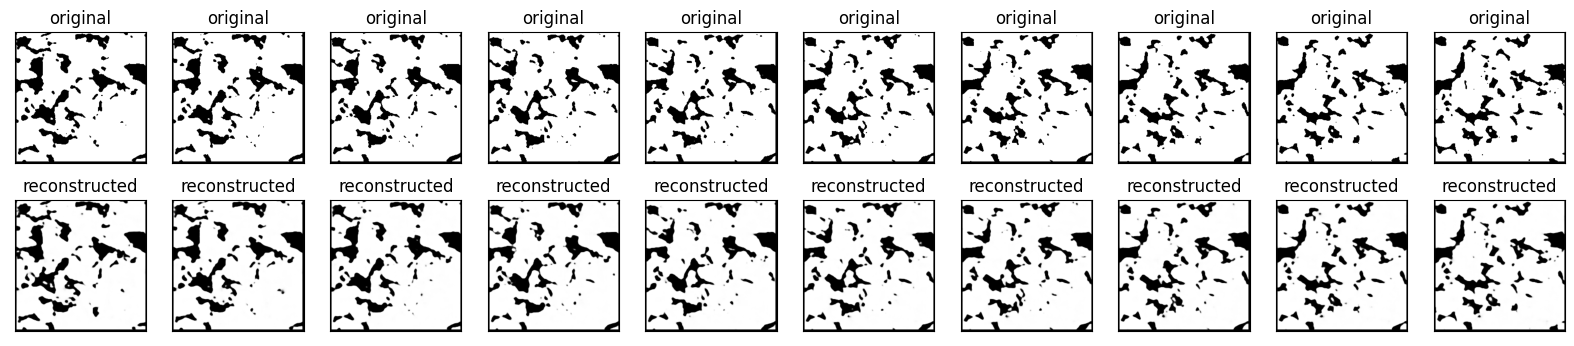

In [26]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(predicted[i].astype("float32"))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [29]:
testing = []
inputLayer = first[0]
# for i in range(len(first)-1):
for i in range(10):

    learned = reconstruction.learnedPrior(inputLayer.reshape(1,256,256,1))
    testing.append(reconstruction.Generate.predict([inputLayer.reshape(1,256,256,1),learned],steps=1))
    inputLayer = testing[-1]

In [30]:
len(testing)

10

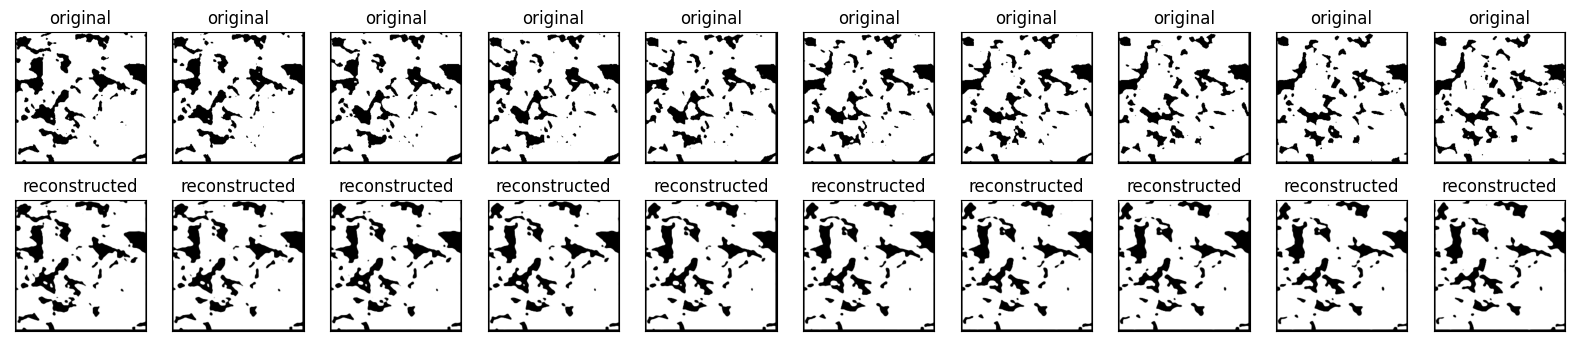

In [31]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [30]:
reconstruction.Generate.save('reconstruction_10batch_10epochs.h5')

D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


NotImplementedError: Layers with arguments in `__init__` must override `get_config`.

In [31]:
file_path = "reconstructed.raw"
testing.insert(0, first[0].reshape(1,256,256,1))
print(len(testing))



250


In [33]:
final = np.array(testing,np.float32).reshape(250,256,256)
final.shape

(250, 256, 256)

In [34]:
file_path = "my_array.npy"
np.save("file", final)

In [35]:
final.tofile(file_path)

In [53]:
Volume = np.fromfile(file_path, dtype=np.uint8)
Volume = Volume.reshape(250,256,256)
Volume.shape

(250, 256, 256)